In [7]:
import numpy as np
import matplotlib
matplotlib.use('Agg')
from matplotlib import gridspec
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import matplotlib.font_manager as font_manager
from rpy2.robjects.packages import importr
from rpy2.robjects.vectors import FloatVector
import matplotlib.pyplot as plt
from matplotlib_venn import venn3, venn3_circles
%matplotlib inline
import copy
stats = importr('stats')

In [8]:
font_dirs = ['/mnt/e/Misc/Python_Fonts', ]
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
font_list = font_manager.createFontList(font_files)
font_manager.fontManager.ttflist.extend(font_list)
matplotlib.rcParams['font.family'] = 'tahoma'

/home/rose/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [9]:
gene_sets = {}
full_gene_list = []
gene_info = {}
#with open('/mnt/e/MPIMG/Elkabetz/AllenBrainAtlas/regional_genes_joined_wk12_to_21.removed_AMY_STR.tsv','r') as gene_sets_fn:
#with open('/mnt/e/MPIMG/Elkabetz/AllenBrainAtlas/regional_genes_joined_wk12_to_21.removed_AMY_STR.tsv','r') as gene_sets_fn:
with open('/mnt/e/MPIMG/Elkabetz/AllenBrainAtlas/regional_genes_joined_wk12_to_21.removed_AMY_STR.merged_all.tsv','r') as gene_sets_fn:
    for row in gene_sets_fn:
        spl = row.strip("\n").split("\t")
        if spl[1] not in gene_sets: gene_sets[spl[1]] = []
        gene_sets[spl[1]].append(spl[0])
        full_gene_list.append(spl[0])
        gene_info[spl[0]]=spl[2]

In [10]:
color_dict = {'CB':'blue','Thalamus':'lime','Cx':'cyan','HIP':'black','STR':'green'}
color_dict = {'CB':'red','Thalamus':'green','Cx':'blue','HIP':'orange','STR':'magenta','AMY':'yellow'}
tx_dict = {'sbnx':'Triple-i','sbn':'Dual-SMADi','nt':'Inhibitor-free','other':'other'}
reg_dict = {'CB':'Mid/Hindbrain','Thalamus':'Diencephalon','Cx':'Neocortex','HIP':'Medial Pallium','other':'other','STR':'Ventral Pallium','AMY':'Amygdala'}
ordered_regs = ['Cx','STR','AMY','HIP','Thalamus','CB']
ordered_regs = ['Cx','HIP','Thalamus','CB']

In [11]:
sig_deseq_subset = {}

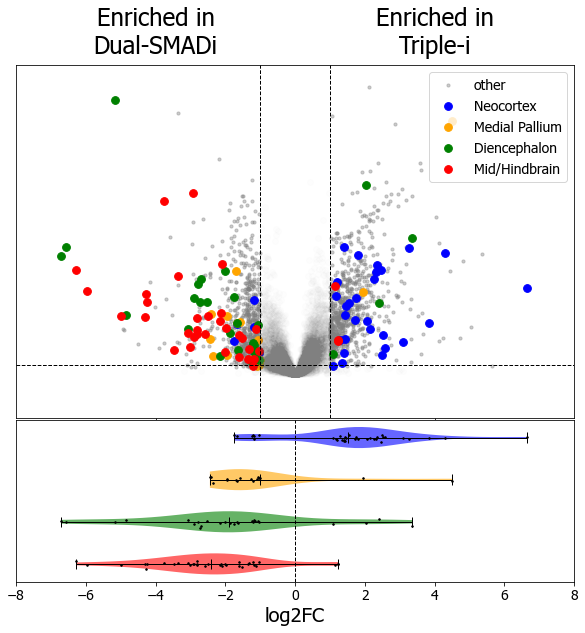

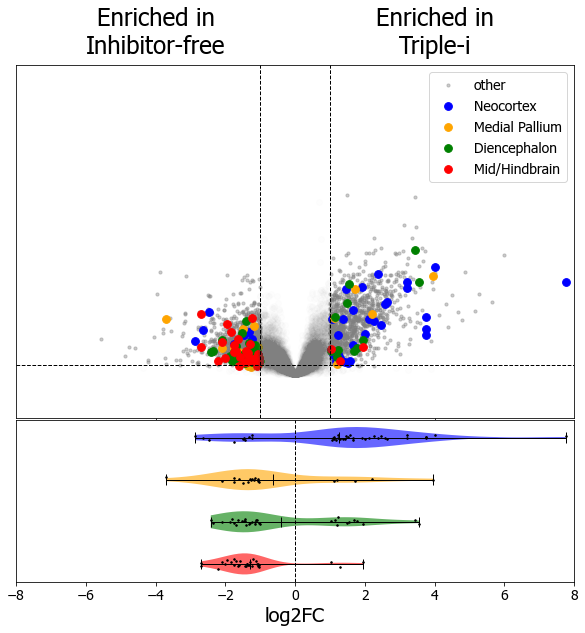

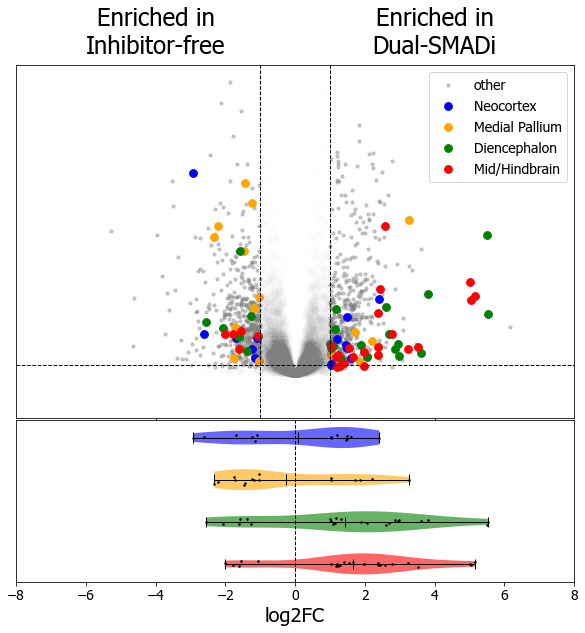

In [12]:
for comp in ['sbnx_sbn','sbnx_nt','sbn_nt']:
    sig_deseq_subset[comp] = {}
    deseq_data = {}
    with open('/mnt/e/MPIMG/Rotation/elkabetz/microcephaly/runs/deseq_run_d30_'+comp+'.tsv','r') as deseq_fn:
        for i,row in enumerate(deseq_fn):
            spl = row.strip("\n\r").split("\t")
            if i == 0:
                continue
            if spl[-1] == 'NA': continue
            deseq_data[spl[0]] = [float(spl[2]),float(spl[-2]),float(spl[-1])]

    deseq_subset = {}
    for gene in deseq_data:
        deseq_subset[gene] = deseq_data[gene]

    sorted_subset = sorted(deseq_subset.items(),key=lambda x:x[1][1])
    pvalue_list = [x[1][1] for x in sorted_subset]
    p_adjust = list(stats.p_adjust(FloatVector(pvalue_list), method = 'BH'))
    for j,gene in enumerate(sorted_subset):
        deseq_subset[gene[0]].append(p_adjust[j])

    for gene in deseq_subset:
        if deseq_subset[gene][-1] < 0.1 and abs(deseq_subset[gene][0]) > 1:
            sig_deseq_subset[comp][gene] = deseq_subset[gene]
            
    use_bp = False
    plt.figure(figsize=(10,10))
    gs = gridspec.GridSpec(20, 1,wspace=0.05, hspace=0.05)
    ax = plt.subplot(gs[1:14])
    fs = 10
    alph_sig_reg=1.0
    alph_sig_other=0.4
    alpha_non_sig=0.01
    s=60
    s_sig_other=10
    sig_reg_genes = []
    sig_other_genes = []
    plot_xy = {}
    y_max = 0
    for x in deseq_data.items():
        val = [x[1][0],-np.log(x[1][-1])/np.log(10)]
        plot_xy[x[0]] = val
        if x[1][1] < 0.1 and abs(x[1][0]) > 1:
            if x[0] in full_gene_list:
                y_max = max(y_max,val[1])
                #plt.annotate(x[0],xy=val,fontsize=fs)
                sig_reg_genes.append(x[0])
            else:
                sig_other_genes.append(x[0])
    plt.scatter([plot_xy[gene][0] for gene in sig_other_genes],[plot_xy[gene][1] for gene in sig_other_genes],
                color='gray',label='other',alpha=alph_sig_other,s=s_sig_other)
    for reg in ordered_regs:
        reg_genes = set(gene_sets[reg]).intersection(sig_reg_genes)
        plt.scatter([plot_xy[gene][0] for gene in reg_genes],[plot_xy[gene][1] for gene in reg_genes],
                    color=color_dict[reg],label=reg_dict[reg],alpha=alph_sig_reg,s=s)
    other_genes = set(plot_xy.keys())-set(sig_reg_genes)-set(sig_other_genes)
    plt.scatter([plot_xy[gene][0] for gene in other_genes],[plot_xy[gene][1] for gene in other_genes],
                color='gray',alpha=alpha_non_sig)
    plt.axvline(1,linestyle='--',linewidth=1,color='black')
    plt.axvline(-1,linestyle='--',linewidth=1,color='black')
    #xmax = max(abs(plt.xlim()[0]),abs(plt.xlim()[1]))
    plt.xlim(-8,8)
    plt.ylim(-5,35)
    #plt.ylim(-y_max*0.1,y_max*0.1+y_max)
    #plt.xticks([])
    plt.legend(fontsize=14,loc='upper right')
    #plt.ylabel('-log10 pval',fontsize=20)

    #plt.title('Enriched in\n'+tx_dict[comp.split("_")[0]]+' '*20+'Enriched in\n'+tx_dict[comp.split("_")[1]],fontsize=24)
    plt.xticks([-4,4],['Enriched in\n'+tx_dict[comp.split("_")[1]],'Enriched in\n'+tx_dict[comp.split("_")[0]]],fontsize=24)
    ax.xaxis.set_tick_params(labeltop='on')
    #plt.yticks(fontsize=14)
    plt.yticks([])
    plt.axhline(-np.log(0.1)/np.log(10),linestyle='--',linewidth=1,color='black')

    ax = plt.subplot(gs[14:])

    regs = copy.deepcopy(ordered_regs)
    regs.reverse()
    positions = []
    vals = []
    colors = []
    for j,reg in enumerate(regs):
        colors.append(color_dict[reg])
        vals.append([plot_xy[gene][0] for gene in gene_sets[reg] if gene in plot_xy and gene in sig_reg_genes])
        #vals.append([plot_xy[gene][0] for gene in gene_sets[reg] if gene in plot_xy and deseq_data[gene][1] < 0.1])
        #vals.append([plot_xy[gene][0] for gene in gene_sets[reg] if gene in plot_xy])# and deseq_data[gene][1] < 0.1])
        positions.append(j)

    if not use_bp:
        vp = ax.violinplot(vals, positions, points=40, widths=0.5,
                          showmeans=True, showextrema=True,
                          vert=False)
        for j,patch in enumerate(vp['bodies']):
            patch.set_facecolor(colors[j])
            patch.set_alpha(0.6)
        for feature in ['cbars','cmins','cmaxes','cmeans']:
            vp[feature].set_color('black')
            vp[feature].set_linewidth(1)
    else:
        bp = ax.boxplot(vals,positions=positions,showfliers=False,vert=False, patch_artist=True,zorder=1)
        for j,patch in enumerate(bp['boxes']):
            patch.set_facecolor(color=colors[j])
        for j,whisker in enumerate(bp['whiskers']):
            whisker.set(color='black', linewidth=1)
        for j,cap in enumerate(bp['caps']):
            cap.set(color='black', linewidth=1)
        for j,median in enumerate(bp['means']):
            median.set(color='black', linewidth=1)

    ## make point plots
    for val,pos,col in zip(vals,positions,colors):
        plt.plot(val,[pos]*len(val)+np.random.randn(len(val))*0.05,'.',markersize=3,color='black',zorder=2)

    #plt.yticks(range(len(regs)-1,-1,-1),[reg_dict[reg] for reg in ordered_regs],fontsize=16)
    plt.yticks([])
    plt.axvline(0,color='black',linewidth=1,linestyle='--')
    plt.xlabel('region')
    plt.xlabel('log2FC',fontsize=20)
    plt.xlim(-8,8)
    plt.xticks(np.linspace(-8,8,9),fontsize=14)
    plt.show()
    #plt.savefig('/mnt/e/MPIMG/Elkabetz/Figures/Volcano_Plots_v3/'+comp+'.merged_all.pdf')
